<a href="https://colab.research.google.com/github/pragmalingu/experiments/blob/master/Experiment/Second_Experiment_BERT_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second Experiment



For our second experiment we connect the Notebook to an Elasticsearch instance and compare a standard Elasticsearch operator with Embeddings we get from BERT (Bi-Directional Encoder Representation from Transformer). The Embeddings are indexed built-in stemming methods: 'Stemmer Token Filter' and 'Hunspell Token Filter'. 
(To read details about this experiment visit our [website](https://pragmalingu.de/docs/experiments/experiment1))

## Setup an Elasticsearch Instance in Google Colab

Everthing to connect to Elasticsearch, for detailed explaination see [this Notebook.](https://)
Download:

In [1]:
import os
from subprocess import Popen, PIPE, STDOUT
# download elasticsearch
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.1-linux-x86_64.tar.gz -q
!tar -xzf elasticsearch-7.9.1-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.9.1


Start a local server:

In [2]:
# start server
es_server = Popen(['elasticsearch-7.9.1/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )
# client-side
!pip install elasticsearch -q
from elasticsearch import Elasticsearch
from datetime import datetime
es = Elasticsearch(["localhost:9200/"])
#wait a bit
import time
time.sleep(30)
es.ping()  # got True

     |████████████████████████████████| 225kB 4.5MB/s 


True

In [3]:
#print new index list
create_response = es.cat.indices()
print(create_response)

## Download and intializie pretrained BERT model

In [4]:
!pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer
import torch
from tqdm import tqdm_notebook

model = SentenceTransformer('bert-base-nli-mean-tokens')

# using gpu to boost inference if it's possible
if torch.cuda.is_available():
  model.to('cuda')

print('Max Sequence Length:', model.max_seq_length)

#Change the length to max possible length (based on gpu memory)
model.max_seq_length = 364

print('Max Sequence Length:', model.max_seq_length)

     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 1.1MB 13.7MB/s 
     |████████████████████████████████| 1.1MB 47.4MB/s 
     |████████████████████████████████| 3.0MB 56.2MB/s 
     |████████████████████████████████| 890kB 47.7MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.8-cp36-none-any.whl size=101996 sha256=792b969d8fc10fc693d6dd5aa716142b1e810a381783dd95935b1ed3ad51181a
  Stored in directory: /root/.cache/pip/wheels/27/ec/b3/d12cc8e4daf77846db6543033d3a5642f204c0320b15945647
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=8afa2fe8093bd204f3eccb003994b10f64e72f2a9532ea77f41173e9c4eed355
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


100%|██████████| 405M/405M [00:23<00:00, 17.1MB/s]


Max Sequence Length: 128
Max Sequence Length: 364


## Parse Data

Get different corpora, format them and feed them to elasticsearch

### ADI Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/adi/).  <br>
For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/private_experiments/blob/adi_corpus/ADICorpus.ipynb) or for parsing in generel read [this guide](https://).

**Parsing**

In [5]:
# download and unzip data
!wget https://nextcloud.samyateia.de/index.php/s/ZWpy29gH4D2sADY/download
!tar -xf download
!rm download

# set paths to the dowloaded data as variables
PATH_TO_ADI_TXT = '/content/ADI.ALL'
PATH_TO_ADI_QRY = '/content/ADI.QRY'
PATH_TO_ADI_REL = '/content/ADI.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np


# get the text and query files

ID_marker = re.compile('\.I')

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read().replace('\n'," ")
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

adi_txt_list = get_data(PATH_TO_ADI_TXT, ID_marker)
adi_qry_list = get_data(PATH_TO_ADI_QRY, ID_marker)

# process text file

adi_title_start = re.compile('\.T')
adi_author_start = re.compile('\.A')
adi_text_start = re.compile('\.W')

adi_txt_data = defaultdict(dict)

for line in adi_txt_list:
  entries = re.split(adi_title_start,line,1)
  id = entries[0].strip()
  no_id = entries[1]
  if len(re.split(adi_author_start, no_id,1)) > 1:
    no_id_entries = re.split(adi_author_start, no_id,1)
    adi_txt_data[id]['title'] = no_id_entries[0]
    no_title = no_id_entries[1]
    no_title_entries = re.split(adi_text_start, no_title)
    adi_txt_data[id]['author'] = no_title_entries[0]
    adi_txt_data[id]['text'] = no_title_entries[1]
  else:
    no_id_entries = re.split(adi_text_start, no_id)
    adi_txt_data[id]['title'] = no_id_entries[0]
    adi_txt_data[id]['text'] = no_id_entries[1]

# process query file    

qry_chunk_start = re.compile('\.W')
adi_qry_data = defaultdict(dict)

for n in range(0,len(adi_qry_list)-1):
  line = adi_qry_list[n+1]
  _ , question = re.split(qry_chunk_start,line)
  adi_qry_data[n+1]['question'] = question

# process relevance assesment

adi_rel_data = open(PATH_TO_ADI_REL)
adi_np = np.loadtxt(adi_rel_data, dtype=float)

adi_rel = defaultdict(list)
for row in adi_np:
  adi_rel[int(row[0])].append(int(row[1])) 

--2020-10-20 13:57:31--  https://nextcloud.samyateia.de/index.php/s/ZWpy29gH4D2sADY/download
Resolving nextcloud.samyateia.de (nextcloud.samyateia.de)... 194.55.14.32
Connecting to nextcloud.samyateia.de (nextcloud.samyateia.de)|194.55.14.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57344 (56K) [application/x-gzip]
Saving to: ‘download’

download            100%[===================>]  56.00K   198KB/s    in 0.3s    

2020-10-20 13:57:32 (198 KB/s) - ‘download’ saved [57344/57344]



**Indexing**

In [6]:
# Elasticsearch settings, without using Opendistro
settings_text = {
  "mappings": {
      "properties": {
          "text": {
              "type": "text"
              },
          "text_vector": {
           "type": "dense_vector",
           "dims": 768
            }
    }
  }
}

settings_title = {
  "mappings": {
      "properties": {
          "title": {
              "type": "text"
              },
          "title_vector": {
           "type": "dense_vector",
           "dims": 768
            }
    }
  }
}

#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
adi_index_text = "bert-text-adi-corpus"
es.indices.delete(index=adi_index_text, ignore=[400, 404])
es.indices.create(adi_index_text, body=settings_text)

adi_index_title = "bert-title-adi-corpus"
es.indices.delete(index=adi_index_title, ignore=[400, 404])
es.indices.create(adi_index_title, body=settings_title)

adi_index = "adi-corpus"
es.indices.delete(index=adi_index, ignore=[400, 404])
es.indices.create(adi_index)

{'acknowledged': True, 'index': 'adi-corpus', 'shards_acknowledged': True}

In [7]:
for ID, doc_data in adi_txt_data.items():
    es.index(index=adi_index, id=ID, body=doc_data)
    es.index(
      index=adi_index_text, 
      id=ID, 
      body={
          'text_vector': model.encode(adi_txt_data[ID]['text']),
          'text': adi_txt_data[ID]['text']
          }
    )
    es.index(
      index=adi_index_title, 
      id=ID, 
      body={
          'title_vector': model.encode(adi_txt_data[ID]['title']),
          'title': adi_txt_data[ID]['title'],
          }
    )

#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-title-adi-corpus wjb1Za6tReee1yY1cWAPKw 1 1 73 0   1.1mb   1.1mb
yellow open bert-text-adi-corpus  S_CFkjyaSzeblkt7PPHd7g 1 1 82 0   1.2mb   1.2mb
yellow open adi-corpus            tN2i3LphQOSzvRj-xd6sUg 1 1 76 0 108.3kb 108.3kb



### CACM Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/).  <br>
For detailed information about the format of the files, see the PragmaLingu [ Benchmarks](https://pragmalingu.de/docs/benchmarks/overview)

**Parsing**

In [8]:
# download and unzip data
!wget https://nextcloud.samyateia.de/index.php/s/s4WQLTc7DLYsAaZ/download
!tar -xf download
!rm download

# set paths to the dowloaded data as variablesDownload and unzip data.

PATH_TO_CACM_TXT = '/content/cacm.all'
PATH_TO_CACM_QRY = '/content/query.text'
PATH_TO_CACM_REL = '/content/qrels.text'
PATH_TO_CACM_COMMON_WORDS = '/content/common_words'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np

# get the text and query files

ID_marker = re.compile('^\.I',re.MULTILINE)

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read()
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

cacm_txt_list = get_data(PATH_TO_CACM_TXT, ID_marker)
cacm_qry_list = get_data(PATH_TO_CACM_QRY, ID_marker)

# process text file

cacm_chunk_title = re.compile('\.[T]\n')
cacm_chunk_txt = re.compile('\n\.W\n') # not enough
cacm_chunk_txt_pub = re.compile('\.[W,B]')
cacm_chunk_publication = re.compile('\.[B]\n')
cacm_chunk_author = re.compile('^\.[A]\n', re.MULTILINE)
cacm_chunk_author_add_cross = re.compile('^\.[A,N,X]\n',re.MULTILINE) # not enough
cacm_chunk_add_cross = re.compile('\.[B,N,X]\n')


cacm_txt_data = defaultdict(dict)

for line in cacm_txt_list:
  entries= re.split(cacm_chunk_title,line)
  id = entries[0].strip() #save id
  no_id = entries[1]

  if len(re.split(cacm_chunk_txt, no_id)) == 2: # is there text
    no_id_entries = re.split(cacm_chunk_txt_pub, no_id,1)
    cacm_txt_data[id]['title'] = no_id_entries[0].strip() # save title
    cacm_txt_data[id]['text'] = no_id_entries[1].strip() # save text
    no_title_txt = no_id_entries[1]

    if len(re.split(cacm_chunk_author, no_title_txt)) == 2: # is there a auhtor
      no_title_entries = re.split(cacm_chunk_author_add_cross, no_title_txt)
      cacm_txt_data[id]['publication_date'] = no_title_entries[0].strip() # save publication date
      cacm_txt_data[id]['author'] = no_title_entries[1].strip() # save athor
      cacm_txt_data[id]['add_date'] = no_title_entries[2].strip() # save add date
      cacm_txt_data[id]['cross-references'] = no_title_entries[3].strip() # save cross-references

    else:
      no_title_entries = re.split(cacm_chunk_publication, no_title_txt)
      cacm_txt_data[id]['publication_date'] = no_title_entries[0].strip() # save publication date
      cacm_txt_data[id]['add_date'] = no_title_entries[1].strip() # save add date
      cacm_txt_data[id]['cross-references'] = no_title_entries[1].strip() # save cross-references

  else:
    no_id_entries = re.split(cacm_chunk_publication, no_id,1)
    cacm_txt_data[id]['title'] = no_id_entries[0].strip() # save title
    no_title = no_id_entries[1]

    if len(re.split(cacm_chunk_author, no_title,1)) == 2: # is there a auhtor
      no_title_entries = re.split(cacm_chunk_author_add_cross, no_title)
      cacm_txt_data[id]['publication_date'] = no_title_entries[0].strip() # save publication date
      cacm_txt_data[id]['author'] = no_title_entries[1].strip() # save athor
      cacm_txt_data[id]['add_date'] = no_title_entries[2].strip() # save add date
      cacm_txt_data[id]['cross-references'] = no_title_entries[3].strip() # save cross-references

    else:
      no_title_entries = re.split(cacm_chunk_add_cross, no_title)
      cacm_txt_data[id]['publication_date'] = no_title_entries[0].strip() # save publication date
      cacm_txt_data[id]['add_date'] = no_title_entries[1].strip() # save add date
      cacm_txt_data[id]['cross-references'] = no_title_entries[2].strip() # save cross-references

# process the query data

qry_chunk_start = re.compile('^\.W\n',re.MULTILINE)
cacm_qry_data = defaultdict(dict)

for n in range(0,len(cacm_qry_list)-1):
  line = cacm_qry_list[n+1]
  _ , question = re.split(qry_chunk_start,line)
  cacm_qry_data[n+1]['question'] = question

# process the relevance assesment data
cacm_rel = defaultdict(list)

with open (PATH_TO_CACM_REL,'r') as f:
  for line in f:
    line = re.split(' ',line)
    cacm_rel[int(line[0])].append(line[1])

--2020-10-20 13:57:40--  https://nextcloud.samyateia.de/index.php/s/s4WQLTc7DLYsAaZ/download
Resolving nextcloud.samyateia.de (nextcloud.samyateia.de)... 194.55.14.32
Connecting to nextcloud.samyateia.de (nextcloud.samyateia.de)|194.55.14.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2221056 (2.1M) [application/x-gzip]
Saving to: ‘download’

download            100%[===================>]   2.12M  2.13MB/s    in 1.0s    

2020-10-20 13:57:42 (2.13 MB/s) - ‘download’ saved [2221056/2221056]



**Indexing**

In [9]:
# Elasticsearch settings, without using Opendistro
settings_text = {
  "mappings": {
      "properties": {
          "text": {
              "type": "text"
              },
          "text_vector": {
           "type": "dense_vector",
           "dims": 768
            }
    }
  }
}

settings_title = {
  "mappings": {
      "properties": {
          "title": {
              "type": "text"
              },
          "title_vector": {
           "type": "dense_vector",
           "dims": 768
            }
    }
  }
}

#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
cacm_index_text = "bert-text-cacm-corpus"
es.indices.delete(index=cacm_index_text, ignore=[400, 404])
es.indices.create(cacm_index_text, body=settings_text)

cacm_index_title = "bert-title-cacm-corpus"
es.indices.delete(index=cacm_index_title, ignore=[400, 404])
es.indices.create(cacm_index_title, body=settings_title)

cacm_index= "cacm-corpus"
es.indices.delete(index=cacm_index, ignore=[400, 404])
es.indices.create(cacm_index)

{'acknowledged': True, 'index': 'cacm-corpus', 'shards_acknowledged': True}

In [10]:
model.eval()

for ID, doc_data in cacm_txt_data.items():
    # not every entry has text
    es.index(index=cacm_index, id=ID, body=doc_data)
    if 'text' not in cacm_txt_data[str(ID)]:
      es.index(
        index=cacm_index_text, 
        id=ID, 
        body={
            'text_vector': model.encode('none'),
            'text': ''
            }
             )
    else:
      es.index(
          index=cacm_index_text, 
          id=ID, 
          body={
              'text_vector': model.encode(cacm_txt_data[ID]['text']),
              'text': cacm_txt_data[ID]['text']
              }
               )
    if 'title' not in cacm_txt_data[str(ID)]:
      es.index(
          index=cacm_index_title, 
          id=ID, 
          body={
              'title_vector': model.encode('none'),
              'title': '',
        }
  )
    else:
      es.index(
          index=cacm_index_title, 
          id=ID, 
          body={
              'title_vector': model.encode(cacm_txt_data[ID]['title']),
              'title': cacm_txt_data[ID]['title'],
              }
               )

#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-title-cacm-corpus DbSiZLHmRE2MsWiuvrP6BQ 1 1 450 0  42.4mb  42.4mb
yellow open bert-title-adi-corpus  wjb1Za6tReee1yY1cWAPKw 1 1  82 0   1.2mb   1.2mb
yellow open cacm-corpus            NCss9_IOSz-Q2qUp0iDuKA 1 1 454 0   1.9mb   1.9mb
yellow open bert-text-adi-corpus   S_CFkjyaSzeblkt7PPHd7g 1 1  82 0   1.2mb   1.2mb
yellow open bert-text-cacm-corpus  Cpa6oA2XQcqgnN5AP0-_5w 1 1 448 0  33.5mb  33.5mb
yellow open adi-corpus             tN2i3LphQOSzvRj-xd6sUg 1 1  82 0 119.1kb 119.1kb



### CISI Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cisi/).  <br>
For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/private_experiments/blob/cisi_corpus/CISICorpus.ipynb) or for parsing in generel read [this guide](https://).

**Parsing**

In [11]:
# download and unzip data
!wget https://nextcloud.samyateia.de/index.php/s/ibPgbdqsstrWEAa/download
!tar -xf download
!rm download

# set paths to the dowloaded data as variablesDownload and unzip data.
PATH_TO_CISI_TXT = '/content/CISI.ALL'
PATH_TO_CISI_QRY = '/content/CISI.QRY'
PATH_TO_CISI_REL = '/content/CISI.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np

# get the text and query files

ID_marker = re.compile('^\.I',re.MULTILINE)

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read()
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

cisi_txt_list = get_data(PATH_TO_CISI_TXT, ID_marker)
cisi_qry_list = get_data(PATH_TO_CISI_QRY, ID_marker)

# process text file

cisi_title_start = re.compile('[\n]\.T')
cisi_author_start = re.compile('[\n]\.A')
cisi_date_start = re.compile('[\n]\.B')
cisi_text_start = re.compile('[\n]\.W')
cisi_cross_start = re.compile('[\n]\.X')

cisi_txt_data = defaultdict(dict)

for line in cisi_txt_list:
  entries = re.split(cisi_title_start,line,1)
  id = entries[0].strip()#save the id
  no_id = entries[1] 
  
  if len(re.split(cisi_author_start, no_id)) >= 2: # is there just one author?
    no_id_entries = re.split(cisi_author_start, no_id,1)
    cisi_txt_data[id]['title'] = no_id_entries[0].strip() # save title
    no_title = no_id_entries[1]

    if len(re.split(cisi_date_start, no_title)) > 1: # is there a publication date?
      no_title_entries = re.split(cisi_date_start, no_title)
      cisi_txt_data[id]['author'] = no_title_entries[0].strip() # save athour
      no_author = no_title_entries[1]
      no_author_entries = re.split(cisi_text_start, no_author)
      cisi_txt_data[id]['publication_date'] = no_author_entries[0].strip() # save publication date
      no_author_date = no_author_entries[1]
    else:
      no_title_entries = re.split(cisi_text_start, no_title)
      cisi_txt_data[id]['author'] = no_title_entries[0].strip() # save athour
      no_author_date = no_title_entries[1]

  else:
    no_id_entries = re.split(cisi_author_start, no_id)
    cisi_txt_data[id]['title'] = no_id_entries[0].strip() # save title
    cisi_txt_data[id]['author'] = no_id_entries[1].strip() # save first author
    no_title_entries = re.split(cisi_text_start, no_title)
    cisi_txt_data[id]['author'] += ','+no_title_entries[0].strip() # save second athour
    no_author_date = no_title_entries[1]

  last_entries = re.split(cisi_cross_start, no_author_date)
  cisi_txt_data[id]['text'] = last_entries[0].strip() # save text
  cisi_txt_data[id]['cross-refrences'] = last_entries[1].strip() # save cross refrences

# process query file  

qry_chunk_start = re.compile('[\n]\.W')

cisi_qry_data = defaultdict(dict)

for line in cisi_qry_list:
  id , question = re.split(qry_chunk_start,line)
  id = re.findall('\d{1,3}',id)[0]
  cisi_qry_data[id]['question'] = question

# process the relevance assesment data
cisi_rel = defaultdict(list)

with open (PATH_TO_CISI_REL,'r') as f:
  for line in f:
    line = line.replace(' ','\t')
    line = re.split('\t',line)
    line = list(filter(None, line))
    cisi_rel[str(line[0])].append(str(line[1]))

--2020-10-20 14:01:00--  https://nextcloud.samyateia.de/index.php/s/ibPgbdqsstrWEAa/download
Resolving nextcloud.samyateia.de (nextcloud.samyateia.de)... 194.55.14.32
Connecting to nextcloud.samyateia.de (nextcloud.samyateia.de)|194.55.14.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2385920 (2.3M) [application/x-gzip]
Saving to: ‘download’

download            100%[===================>]   2.28M  2.28MB/s    in 1.0s    

2020-10-20 14:01:03 (2.28 MB/s) - ‘download’ saved [2385920/2385920]



**Indexing**

In [12]:
# Elasticsearch settings, without using Opendistro
settings_text = {
  "mappings": {
      "properties": {
          "text": {
              "type": "text"
              },
          "text_vector": {
           "type": "dense_vector",
           "dims": 768
            }
    }
  }
}

settings_title = {
  "mappings": {
      "properties": {
          "title": {
              "type": "text"
              },
          "title_vector": {
           "type": "dense_vector",
           "dims": 768
            }
    }
  }
}

#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
cisi_index_title = "bert-title-cisi-corpus"
es.indices.delete(index=cisi_index_title, ignore=[400, 404])
es.indices.create(cisi_index_title, body=settings_title)

cisi_index_text = "bert-text-cisi-corpus"
es.indices.delete(index=cisi_index_text, ignore=[400, 404])
es.indices.create(cisi_index_text, body=settings_text)

cisi_index = "cisi-corpus"
es.indices.delete(index=cisi_index, ignore=[400, 404])
es.indices.create(cisi_index)

{'acknowledged': True, 'index': 'cisi-corpus', 'shards_acknowledged': True}

In [13]:
for ID, doc_data in cisi_txt_data.items():
    es.index(
      index=cisi_index_text, 
      id=ID, 
      body={
          'text_vector': model.encode(cisi_txt_data[ID]['text']),
          'text': cisi_txt_data[ID]['text']
          }
    )
    es.index(
      index=cisi_index_title, 
      id=ID, 
      body={
          'title_vector': model.encode(cisi_txt_data[ID]['title']),
          'title': cisi_txt_data[ID]['title'],
          }
    )
    es.index(index=cisi_index, id=ID, body=doc_data)

#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-title-cacm-corpus DbSiZLHmRE2MsWiuvrP6BQ 1 1 450 0  42.4mb  42.4mb
yellow open bert-title-cisi-corpus WQf_ov8kRwOMxaTB-vhkDQ 1 1 438 0  22.1mb  22.1mb
yellow open bert-title-adi-corpus  wjb1Za6tReee1yY1cWAPKw 1 1  82 0   1.2mb   1.2mb
yellow open cacm-corpus            NCss9_IOSz-Q2qUp0iDuKA 1 1 454 0   1.9mb   1.9mb
yellow open bert-text-adi-corpus   S_CFkjyaSzeblkt7PPHd7g 1 1  82 0   1.2mb   1.2mb
yellow open bert-text-cacm-corpus  Cpa6oA2XQcqgnN5AP0-_5w 1 1 448 0  33.5mb  33.5mb
yellow open cisi-corpus            itpkSN0tQtmjSHUefuM8ww 1 1 444 0   2.4mb   2.4mb
yellow open adi-corpus             tN2i3LphQOSzvRj-xd6sUg 1 1  82 0 119.1kb 119.1kb
yellow open bert-text-cisi-corpus  VI2_BFMKTMWroZZwmqElhA 1 1 442 0  23.7mb  23.7mb



### Cranfield Corpus


You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cran/).  <br>
For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/private_experiments/blob/cranfield_corpus/CranfieldCorpus.ipynb) or for parsing in generel read [this guide](https://).

**Parsing**

In [14]:
# download and unzip data
!wget https://nextcloud.samyateia.de/index.php/s/ePSxPpLELCWteeL/download
!tar -xf download
!rm download

# set paths to the dowloaded data as variables
PATH_TO_CRAN_TXT = '/content/cran.all.1400'
PATH_TO_CRAN_QRY = '/content/cran.qry'
PATH_TO_CRAN_REL = '/content/cranqrel'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np


# get the text entries from the text and query files

ID_marker = re.compile('\.I')

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read().replace('\n'," ")
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

cran_txt_list = get_data(PATH_TO_CRAN_TXT, ID_marker)
cran_qry_list = get_data(PATH_TO_CRAN_QRY, ID_marker)

# process text file

cran_chunk_start = re.compile('\.[A,B,T,W]')
cran_txt_data = defaultdict(dict)

for line in cran_txt_list:
  entries= re.split(cran_chunk_start,line)
  id = entries[0].strip()
  title = entries[1]
  author = entries[2]
  publication_date = entries[3]
  text = entries[4:]
  cran_txt_data[id]['title'] = title
  cran_txt_data[id]['author'] = author
  cran_txt_data[id]['publication_date'] = publication_date
  cran_txt_data[id]['text'] = ''.join(text)

# process query file

qry_chunk_start = re.compile('\.W')
cran_qry_data = defaultdict(dict)

for n in range(0,len(cran_qry_list)-1):
  line = cran_qry_list[n+1]
  _ , question = re.split(qry_chunk_start,line)
  cran_qry_data[n+1]['question'] = question

# process relevance assesments without rating
cran_rel = defaultdict(list)

with open (PATH_TO_CRAN_REL,'r') as f:
  for line in f:
    line = re.split(' ',line)
    cran_rel[int(line[0])].append(line[1])

--2020-10-20 14:02:35--  https://nextcloud.samyateia.de/index.php/s/ePSxPpLELCWteeL/download
Resolving nextcloud.samyateia.de (nextcloud.samyateia.de)... 194.55.14.32
Connecting to nextcloud.samyateia.de (nextcloud.samyateia.de)|194.55.14.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1698816 (1.6M) [application/x-gzip]
Saving to: ‘download’

download            100%[===================>]   1.62M  1.92MB/s    in 0.8s    

2020-10-20 14:02:36 (1.92 MB/s) - ‘download’ saved [1698816/1698816]



In [15]:
print(cran_rel)

defaultdict(<class 'list'>, {1: ['184', '29', '31', '12', '51', '102', '13', '14', '15', '57', '378', '859', '185', '30', '37', '52', '142', '195', '875', '56', '66', '95', '462', '497', '858', '876', '879', '880', '486'], 2: ['12', '15', '184', '858', '51', '102', '202', '14', '52', '380', '746', '859', '948', '285', '390', '391', '442', '497', '643', '856', '857', '877', '864', '658', '486'], 3: ['5', '6', '90', '91', '119', '144', '181', '399', '485'], 4: ['236', '166', '488'], 5: ['552', '401', '1297', '1296', '488'], 6: ['99', '115', '257', '258', '491'], 7: ['20', '56', '57', '58', '19', '492'], 8: ['48', '122', '20', '58', '196', '354', '360', '197', '999', '1112', '1005', '492'], 9: ['21', '22', '550', '534'], 10: ['259', '405', '302', '436', '437', '438', '998', '1011', '493'], 11: ['27', '28', '262', '160', '20', '263', '654', '495'], 12: ['86', '194', '650', '649', '652', '624'], 13: ['64', '265', '65', '311', '496'], 14: ['64', '65', '496'], 15: ['463', '462', '497'], 16: [

Too long texts will be cutted to 364 tokens per text

**Indexing**

In [16]:
# Elasticsearch settings, without using Opendistro
settings_text = {
  "mappings": {
      "properties": {
          "text": {
              "type": "text"
              },
          "text_vector": {
           "type": "dense_vector",
           "dims": 768
            }
    }
  }
}

settings_title = {
  "mappings": {
      "properties": {
          "title": {
              "type": "text"
              },
          "title_vector": {
           "type": "dense_vector",
           "dims": 768
            }
    }
  }
}

#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
cran_index_text = "bert-text-cranfield-corpus"
es.indices.delete(index=cran_index_text, ignore=[400, 404])
es.indices.create(cran_index_text, body=settings_text)


cran_index_title = "bert-title-cranfield-corpus"
es.indices.delete(index=cran_index_title, ignore=[400, 404])
es.indices.create(cran_index_title, body=settings_title)

cran_index = "cranfield-corpus"
es.indices.delete(index=cran_index, ignore=[400, 404])
es.indices.create(cran_index)

{'acknowledged': True,
 'index': 'cranfield-corpus',
 'shards_acknowledged': True}

In [17]:
model.eval()
#index documents, see https://elasticsearch-py.readthedocs.io/en/master/#example-usage
for ID, doc_data in cran_txt_data.items():
      # not every entry has text
      es.index(index=cran_index, id=ID, body=doc_data)
      if len(cran_txt_data[str(ID)]['text']) == 1:
        es.index(
            index=cran_index_text, 
            id=ID, 
            body={
                'text_vector': model.encode('none'),
                'text': cran_txt_data[ID]['text']
                }
                 )
      else:
        es.index(
            index=cran_index_text, 
            id=ID, 
            body={
                'text_vector': model.encode(cran_txt_data[ID]['text']),
                'text': cran_txt_data[ID]['text']
                }
                 )
      es.index(
         index=cran_index_title, 
         id=ID, 
         body={
          'title_vector': model.encode(cran_txt_data[ID]['title']),
          'title': cran_txt_data[ID]['title'],
          }
    )

#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-title-cacm-corpus      DbSiZLHmRE2MsWiuvrP6BQ 1 1 450 0  42.4mb  42.4mb
yellow open bert-title-cisi-corpus      WQf_ov8kRwOMxaTB-vhkDQ 1 1 438 0  22.1mb  22.1mb
yellow open bert-title-adi-corpus       wjb1Za6tReee1yY1cWAPKw 1 1  82 0   1.2mb   1.2mb
yellow open bert-text-cranfield-corpus  4oTqJqRQTx-jf0bZ4l6fmA 1 1 434 0  23.3mb  23.3mb
yellow open cranfield-corpus            7ey2SoyATOKlVeKcM0bo2g 1 1 439 0   1.7mb   1.7mb
yellow open bert-title-cranfield-corpus zLjG9ri1SXGW1hz50x_GcA 1 1 436 0  21.4mb  21.4mb
yellow open cacm-corpus                 NCss9_IOSz-Q2qUp0iDuKA 1 1 454 0   1.9mb   1.9mb
yellow open bert-text-adi-corpus        S_CFkjyaSzeblkt7PPHd7g 1 1  82 0   1.2mb   1.2mb
yellow open bert-text-cacm-corpus       Cpa6oA2XQcqgnN5AP0-_5w 1 1 448 0  33.5mb  33.5mb
yellow open cisi-corpus                 itpkSN0tQtmjSHUefuM8ww 1 1 444 0   2.4mb   2.4mb
yellow open bert-text-cisi-corpus       VI2_BFMKTMWroZZwmqElhA 1 1 442 0  23.7mb  23.7mb
yellow open adi-corpu

### LISA Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/lisa/).  <br>
For detailed information about the format of the files, see the PragmaLingu [ Benchmarks](https://pragmalingu.de/docs/benchmarks/overview)

**Parsing**

In [18]:
# download and unzip data
!wget https://nextcloud.samyateia.de/index.php/s/Ed8gekyDgpkGGQ6/download
!tar -xf download
!rm download

# set paths to the dowloaded data as variablesDownload and unzip data.

PATH_TO_LISA_TXT = '/content/'
PATH_TO_LISA_QRY = '/content/LISA.QUE'
PATH_TO_LISA_REL = '/content/LISARJ.NUM'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np
import os

# get the text and query files

file_regex = re.compile('LISA[0-5]')
lisa_files = [i for i in os.listdir(PATH_TO_LISA_TXT) if os.path.isfile(os.path.join(PATH_TO_LISA_TXT,i)) and re.match(file_regex,i)]

txt_entry_marker = re.compile('\*{44}',re.MULTILINE)
qry_entry_marker = re.compile('#')

def get_data(PATH_TO_FILES, marker):
  """
  Reads multiple files and spilts text into entries at the entry marker.
  The 'marker' contains the regex at which we want to split
  Pops last element since it's empty.
  """
  with open (PATH_TO_FILES,'r') as f:
    text = f.read().replace('     ','')
    lines = re.split(marker,text)
    lines.pop()
  return lines

lisa_txt_list = []
for name in lisa_files: 
  lisa_txt_list.extend(get_data(PATH_TO_LISA_TXT+name, txt_entry_marker))

lisa_qry_list = get_data(PATH_TO_LISA_QRY, qry_entry_marker)

# process text file

doc_strip = re.compile('\n?Document {1,2}')

lisa_txt_list_stripped = []
lisa_txt_data = defaultdict(dict)

for el in lisa_txt_list:
  lisa_txt_list_stripped.append(re.sub(doc_strip,'', el))

for entry in lisa_txt_list_stripped:
  parts = entry.split('\n')
  empty_index = parts.index('')
  ID = parts[0].strip(' ')
  title = parts[1:empty_index]
  text = parts[empty_index+1:]
  lisa_txt_data[ID]['title'] = title
  lisa_txt_data[ID]['text'] = ''.join(text)

# process the query data

lisa_qry_data = defaultdict(dict)
# first line is a special case because it doesn't start with a newline
first_line = lisa_qry_list[0]
first_question = ' '.join(first_line[1:])
lisa_qry_data[int(first_line[0])]['question'] = first_question

# after that every line can be handle the same way
for n in range(0,len(lisa_qry_list)-1):
  line = re.split('\n',lisa_qry_list[n+1])
  question = ' '.join(line[2:])
  lisa_qry_data[int(line[1])]['question'] = question

# process relevance assesments
lisa_rel = defaultdict(list)

rel_marker = re.compile('            \n        ')
rel_split = re.compile('\n')

with open (PATH_TO_LISA_REL,'r') as f:
  file = f.read().strip('       ').replace('\n','')
  lines = re.split(' ',file)
  lines = list(filter(None, lines))
  n = 0
  while n < len(lines):
    ID = int(lines[n])
    num_rel = int(lines[n+1])
    rels = lines[(n+2):(n+num_rel+2)]
    lisa_rel[ID].extend(rels)
    n = n+1+num_rel+1

--2020-10-20 14:04:07--  https://nextcloud.samyateia.de/index.php/s/Ed8gekyDgpkGGQ6/download
Resolving nextcloud.samyateia.de (nextcloud.samyateia.de)... 194.55.14.32
Connecting to nextcloud.samyateia.de (nextcloud.samyateia.de)|194.55.14.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4012544 (3.8M) [application/x-gzip]
Saving to: ‘download’

download            100%[===================>]   3.83M  3.28MB/s    in 1.2s    

2020-10-20 14:04:09 (3.28 MB/s) - ‘download’ saved [4012544/4012544]



We will use only texts, because other fields like author or publication_date don't affect on meaning of text.

In [19]:
num_docs_with_texts = 0
num_docs_with_too_long_texts = 0
max_length = 0

docs_to_index = []

for ID, doc_data in lisa_txt_data.items():
  if 'text' in doc_data.keys():
    docs_to_index.append(ID)
    num_docs_with_texts += 1
    length = len(model.tokenize(doc_data['title']))
    if length > 364:
      num_docs_with_too_long_texts += 1
    if length > max_length:
      max_length = length

print(f'Total number of documents: {len(lisa_txt_data)}\n',
  f'Number of documents with "title": {num_docs_with_texts}\n',
  f'Number of documents with too long "title": {num_docs_with_too_long_texts}\n',
  f'Max length of title in tokens: {max_length}')

Total number of documents: 6000
 Number of documents with "title": 6000
 Number of documents with too long "title": 0
 Max length of title in tokens: 5


Too long texts will be cutted to 364 tokens per text

**Indexing**

In [20]:
# Elasticsearch settings, without using Opendistro
settings_text = {
  "mappings": {
      "properties": {
          "text": {
              "type": "text"
              },
          "text_vector": {
           "type": "dense_vector",
           "dims": 768
            }
    }
  }
}

settings_title = {
  "mappings": {
      "properties": {
          "title": {
              "type": "text"
              },
          "title_vector": {
           "type": "dense_vector",
           "dims": 768
            }
    }
  }
}

#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
lisa_index_text = "bert-text-lisa-corpus"
es.indices.delete(index=lisa_index_text, ignore=[400, 404])
es.indices.create(lisa_index_text, body=settings_text)

lisa_index_title = "bert-title-lisa-corpus"
es.indices.delete(index=lisa_index_title, ignore=[400, 404])
es.indices.create(lisa_index_title, body=settings_title)

lisa_index = "lisa-corpus"
es.indices.delete(index=lisa_index, ignore=[400, 404])
es.indices.create(lisa_index)

{'acknowledged': True, 'index': 'lisa-corpus', 'shards_acknowledged': True}

In [21]:
from tqdm import tqdm_notebook
model.eval()
for ID, doc_data in lisa_txt_data.items():
    es.index(
      index=lisa_index_text, 
      id=ID, 
      body={
          'text_vector': model.encode(lisa_txt_data[ID]['text']),
          'text': lisa_txt_data[ID]['text']
          }
    )
    es.index(
      index=lisa_index_title, 
      id=ID, 
      body={
          'title_vector': model.encode(''.join(lisa_txt_data[ID]['title'])),
          'title': lisa_txt_data[ID]['title'],
          }
    )
    es.index(index=lisa_index, id=ID, body=doc_data)
#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-title-lisa-corpus      4APtZ_bBSzWTyJM0A6W0UQ 1 1  472 0  75.1mb  75.1mb
yellow open bert-title-adi-corpus       wjb1Za6tReee1yY1cWAPKw 1 1   82 0   1.2mb   1.2mb
yellow open cranfield-corpus            7ey2SoyATOKlVeKcM0bo2g 1 1 1400 0   1.8mb   1.8mb
yellow open bert-title-cranfield-corpus zLjG9ri1SXGW1hz50x_GcA 1 1 1400 0    20mb    20mb
yellow open bert-text-adi-corpus        S_CFkjyaSzeblkt7PPHd7g 1 1   82 0   1.2mb   1.2mb
yellow open bert-text-lisa-corpus       NXg7AszeTy6p6G-w_ILXhw 1 1  470 0  77.6mb  77.6mb
yellow open adi-corpus                  tN2i3LphQOSzvRj-xd6sUg 1 1   82 0 119.7kb 119.7kb
yellow open lisa-corpus                 FAyDOHysT2OFBqM3QjGXBA 1 1  473 0   2.7mb   2.7mb
yellow open bert-title-cacm-corpus      DbSiZLHmRE2MsWiuvrP6BQ 1 1 3204 0  46.3mb  46.3mb
yellow open bert-title-cisi-corpus      WQf_ov8kRwOMxaTB-vhkDQ 1 1 1460 0  21.1mb  21.1mb
yellow open bert-text-cranfield-corpus  4oTqJqRQTx-jf0bZ4l6fmA 1 1 1400 0  21.9mb  21.9mb
yellow ope

## Evaluation

### Recall

In this section we only evaluate the Recall scores.

**Multi Match Query**

Here we evaluate the data with the ["multi_match"](https://pragmalingu.de/docs/experiments/experiment1#standard-elasticsearch) option of elastic search:

In [22]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-simple-query-string-query.html 

import json
from collections import defaultdict

adi_index = 'adi-corpus'
cacm_index = 'cacm-corpus'
cisi_index = 'cisi-corpus'
cran_index = 'cranfield-corpus'
lisa_index = 'lisa-corpus'

#function to get normal match evaluation body 
def create_query_body_match_recall(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests": '',
      "metric": {
          "recall": {
              "relevant_rating_threshold": 1,
              "k": 20
              }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {"query": { "multi_match": { "query": '' , "fields" : ["title"]}}}
    current_query["query"]["multi_match"]["query"] = query_txt['question']
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{"_index": index_name, "_id": str(el), "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


#ADI
adi_create_match_recall = create_query_body_match_recall(adi_qry_data, adi_rel, adi_index)
adi_eval_body_match_recall = json.dumps(adi_create_match_recall)
adi_res_match_recall = es.rank_eval(adi_eval_body_match_recall, adi_index)
#print(json.dumps(adi_res_match_recall, indent=4, sort_keys=True))

#CACM
cacm_create_match_recall = create_query_body_match_recall(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_match_recall = json.dumps(cacm_create_match_recall)
cacm_res_match_recall = es.rank_eval(cacm_eval_body_match_recall,cacm_index)
#print(json.dumps(cacm_res_match_recall, indent=4, sort_keys=True))

#CISI
cisi_create_match_recall = create_query_body_match_recall(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_match_recall = json.dumps(cisi_create_match_recall)
cisi_res_match_recall = es.rank_eval(cisi_eval_body_match_recall, cisi_index)
#print(json.dumps(cisi_res_match_recall, indent=4, sort_keys=True))

#Cranfield
cran_create_match_recall = create_query_body_match_recall(cran_qry_data, cran_rel, cran_index)
cran_eval_body_match_recall = json.dumps(cran_create_match_recall)
cran_res_match_recall = es.rank_eval(cran_eval_body_match_recall, cran_index)
#print(json.dumps(cran_create_match_recall, indent=4, sort_keys=True))

#LISA
lisa_create_match_recall = create_query_body_match_recall(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_match_recall = json.dumps(lisa_create_match_recall)
lisa_res_match_recall = es.rank_eval(lisa_eval_body_match_recall,lisa_index)
#print(json.dumps(lisa_res_match_recall, indent=4, sort_keys=True))

**BERT Sentence Embbedings on 'title' field**

In [23]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'bert-title-adi-corpus'
cacm_index = 'bert-title-cacm-corpus'
cisi_index = 'bert-title-cisi-corpus'
cran_index = 'bert-title-cranfield-corpus'
lisa_index = 'bert-title-lisa-corpus'

# function to get normal match evaluation body 

def create_query_body_bert_title_recall(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "recall": {
          "k" : 20,
          "relevant_rating_threshold": 1,
          #"ignore_unlabeled": "false"
          }
         }
      }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {
        "query" : {
  "script_score": {
    "query": {"match_all": {}},
    "script": {
      "source": "cosineSimilarity(params.query_vector, doc['title_vector']) + 1.0",
      "params": {"query_vector": list(model.encode(query_txt['question']).astype(float))}
    }
  }
  }
    }
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{
          "_index": index_name, 
          "_id": str(el) if type(el) != tuple else str(el[0]), 
          "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


# ADI

adi_create_bert_title_recall = create_query_body_bert_title_recall(adi_qry_data, adi_rel, adi_index)
adi_eval_body_bert_title_recall = json.dumps(adi_create_bert_title_recall)
adi_res_bert_title_recall = es.rank_eval(adi_eval_body_bert_title_recall, adi_index)
#print(json.dumps(adi_res_bert_title_recall, indent=4, sort_keys=True))

# CACM

cacm_create_bert_title_recall = create_query_body_bert_title_recall(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_bert_title_recall = json.dumps(cacm_create_bert_title_recall)
cacm_res_bert_title_recall = es.rank_eval(cacm_eval_body_bert_title_recall, cacm_index)
#print(json.dumps(cacm_res_bert_title_recall, indent=4, sort_keys=True))

# CISI

cisi_create_bert_title_recall = create_query_body_bert_title_recall(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_bert_title_recall = json.dumps(cisi_create_bert_title_recall)
cisi_res_bert_title_recall = es.rank_eval(cisi_eval_body_bert_title_recall, cisi_index)
#print(json.dumps(cisi_res_bert_title_recall, indent=4, sort_keys=True))

# Cranfield

cran_create_bert_title_recall = create_query_body_bert_title_recall(cran_qry_data, cran_rel, cran_index)
cran_eval_body_bert_title_recall = json.dumps(cran_create_bert_title_recall)
cran_res_bert_title_recall = es.rank_eval(cran_eval_body_bert_title_recall, cran_index)
#print(json.dumps(cran_res_bert_title_recall, indent=4, sort_keys=True))

# LISA

lisa_create_bert_title_recall = create_query_body_bert_title_recall(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_bert_title_recall = json.dumps(lisa_create_bert_title_recall)
lisa_res_bert_title_recall = es.rank_eval(lisa_eval_body_bert_title_recall, lisa_index)
#print(json.dumps(lisa_res_bert_title_recall, indent=4, sort_keys=True))

/usr/local/lib/python3.6/dist-packages/elasticsearch/connection/base.py:190: ElasticsearchDeprecationWarning: The vector functions of the form function(query, doc['field']) are deprecated, and the form function(query, 'field') should be used instead. For example, cosineSimilarity(query, doc['field']) is replaced by cosineSimilarity(query, 'field').
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


### Precision

In this section we only evaluate the Precision scores.

**Multi Match Query**

Here we evaluate the data with the ["multi_match"](https://pragmalingu.de/docs/experiments/experiment1#standard-elasticsearch) option of elastic search:

In [24]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-simple-query-string-query.html 

import json
from collections import defaultdict

adi_index = 'adi-corpus'
cacm_index = 'cacm-corpus'
cisi_index = 'cisi-corpus'
cran_index = 'cranfield-corpus'
lisa_index = 'lisa-corpus'

#function to get normal match evaluation body 
def create_query_body_match_precision(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests": '',
      "metric": {
          "precision": {
              "relevant_rating_threshold": 1,
              "k": 20
              }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {"query": { "multi_match": { "query": '' , "fields" : ["title"]}}}
    current_query["query"]["multi_match"]["query"] = query_txt['question']
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{"_index": index_name, "_id": str(el), "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


#ADI
adi_create_match_precision= create_query_body_match_precision(adi_qry_data, adi_rel, adi_index)
adi_eval_body_match_precision = json.dumps(adi_create_match_precision)
adi_res_match_precision = es.rank_eval(adi_eval_body_match_precision, adi_index)
#print(json.dumps(adi_res_match_precision, indent=4, sort_keys=True))

#CACM
cacm_create_match_precision = create_query_body_match_precision(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_match_precision = json.dumps(cacm_create_match_precision)
cacm_res_match_precision = es.rank_eval(cacm_eval_body_match_precision,cacm_index)
#print(json.dumps(cacm_res_match_precision, indent=4, sort_keys=True))

#CISI
cisi_create_match_precision = create_query_body_match_precision(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_match_precision = json.dumps(cisi_create_match_precision)
cisi_res_match_precision = es.rank_eval(cisi_eval_body_match_precision, cisi_index)
#print(json.dumps(cisi_res_match_precision, indent=4, sort_keys=True))

#Cranfield
cran_create_match_precision = create_query_body_match_precision(cran_qry_data, cran_rel, cran_index)
cran_eval_body_match_precision = json.dumps(cran_create_match_precision)
cran_res_match_precision = es.rank_eval(cran_eval_body_match_precision, cran_index)
#print(json.dumps(cran_res_match_precision, indent=4, sort_keys=True))

#LISA
lisa_create_match_precision = create_query_body_match_precision(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_match_precision = json.dumps(lisa_create_match_precision)
lisa_res_match_precision = es.rank_eval(lisa_eval_body_match_precision,lisa_index)
#print(json.dumps(lisa_res_match_precision, indent=4, sort_keys=True))

**BERT Sentence Embeddings on 'title' field**

In [25]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'bert-title-adi-corpus'
cacm_index = 'bert-title-cacm-corpus'
cisi_index = 'bert-title-cisi-corpus'
cran_index = 'bert-title-cranfield-corpus'
lisa_index = 'bert-title-lisa-corpus'

# function to get normal match evaluation body 

def create_query_body_bert_title_precision(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "precision": {
            "k" : 20,
            "relevant_rating_threshold": 1,
            #"ignore_unlabeled": "false"
            }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {
        "query" : {
  "script_score": {
    "query": {"match_all": {}},
    "script": {
      "source": "cosineSimilarity(params.query_vector, doc['title_vector']) + 1.0",
      "params": {"query_vector": list(model.encode(query_txt['question']).astype(float))}
    }
  }
  }
    }
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{
          "_index": index_name, 
          "_id": str(el) if type(el) != tuple else str(el[0]), 
          "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


# ADI

adi_create_bert_title_precision = create_query_body_bert_title_recall(adi_qry_data, adi_rel, adi_index)
adi_eval_body_bert_title_precision = json.dumps(adi_create_bert_title_precision)
adi_res_bert_title_precision = es.rank_eval(adi_eval_body_bert_title_precision, adi_index)
#print(json.dumps(adi_res_bert_title_precision, indent=4, sort_keys=True))

# CACM

cacm_create_bert_title_precision = create_query_body_bert_title_precision(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_bert_title_precision = json.dumps(cacm_create_bert_title_precision)
cacm_res_bert_title_precision = es.rank_eval(cacm_eval_body_bert_title_precision, cacm_index)
#print(json.dumps(cacm_res_bert_title_precision, indent=4, sort_keys=True))

# CISI

cisi_create_bert_title_precision = create_query_body_bert_title_precision(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_bert_title_precision = json.dumps(cisi_create_bert_title_precision)
cisi_res_bert_title_precision = es.rank_eval(cisi_eval_body_bert_title_precision, cisi_index)
#print(json.dumps(cisi_res_bert_title_precision, indent=4, sort_keys=True))

# Cranfield

cran_create_bert_title_precision = create_query_body_bert_title_precision(cran_qry_data, cran_rel, cran_index)
cran_eval_body_bert_title_precision = json.dumps(cran_create_bert_title_precision)
cran_res_bert_title_precision = es.rank_eval(cran_eval_body_bert_title_precision, cran_index)
#print(json.dumps(cran_res_bert_title_precision, indent=4, sort_keys=True))

# LISA

lisa_create_bert_title_precision = create_query_body_bert_title_precision(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_bert_title_precision = json.dumps(lisa_create_bert_title_precision)
lisa_res_bert_title_precision = es.rank_eval(lisa_eval_body_bert_title_precision, lisa_index)
#print(json.dumps(lisa_res_bert_title_precision, indent=4, sort_keys=True))

/usr/local/lib/python3.6/dist-packages/elasticsearch/connection/base.py:190: ElasticsearchDeprecationWarning: The vector functions of the form function(query, doc['field']) are deprecated, and the form function(query, 'field') should be used instead. For example, cosineSimilarity(query, doc['field']) is replaced by cosineSimilarity(query, 'field').
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


## Visualisation

Here we visualize our results:

### Recall

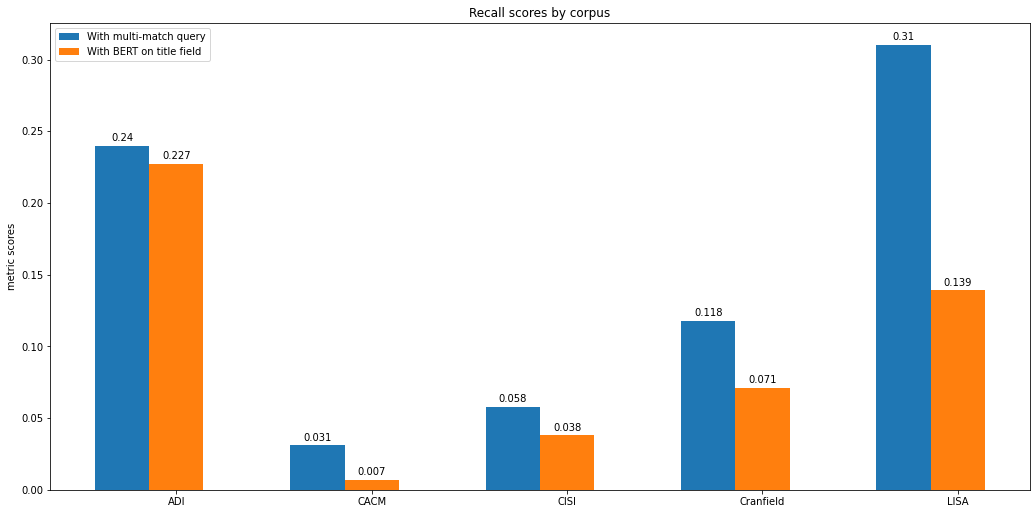

In [26]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

match_metrics_recall = []
match_metrics_recall.append(round(adi_res_match_recall['metric_score'], 3))
match_metrics_recall.append(round(cacm_res_match_recall['metric_score'], 3))
match_metrics_recall.append(round(cisi_res_match_recall['metric_score'], 3))
match_metrics_recall.append(round(cran_res_match_recall['metric_score'], 3))
match_metrics_recall.append(round(lisa_res_match_recall['metric_score'], 3))

bert_title_metrics_recall = []
bert_title_metrics_recall.append(round(adi_res_bert_title_recall['metric_score'], 3))
bert_title_metrics_recall.append(round(cacm_res_bert_title_recall['metric_score'], 3))
bert_title_metrics_recall.append(round(cisi_res_bert_title_recall['metric_score'], 3))
bert_title_metrics_recall.append(round(cran_res_bert_title_recall['metric_score'], 3))
bert_title_metrics_recall.append(round(lisa_res_bert_title_recall['metric_score'], 3))

labels = ['ADI','CACM', 'CISI','Cranfield', 'LISA']

x = np.arange(len(labels))*1.8  # the label locations

width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, match_metrics_recall , width, label='With multi-match query')
rects2 = ax.bar(x, bert_title_metrics_recall, width, label='With BERT on title field')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('Recall scores by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()

In [27]:
from tabulate import tabulate

match_metrics_recall.insert(0, 'multi-match query')  
bert_title_metrics_recall.insert(0, 'BERT on title field')

l = [match_metrics_recall, bert_title_metrics_recall]
table = tabulate(l, headers=['ADI','CACM', 'CISI','cranfield', 'LISA'], tablefmt='orgtbl')

print(table)

|                     |   ADI |   CACM |   CISI |   cranfield |   LISA |
|---------------------+-------+--------+--------+-------------+--------|
| multi-match query   | 0.24  |  0.031 |  0.058 |       0.118 |  0.31  |
| BERT on title field | 0.227 |  0.007 |  0.038 |       0.071 |  0.139 |


### Precision

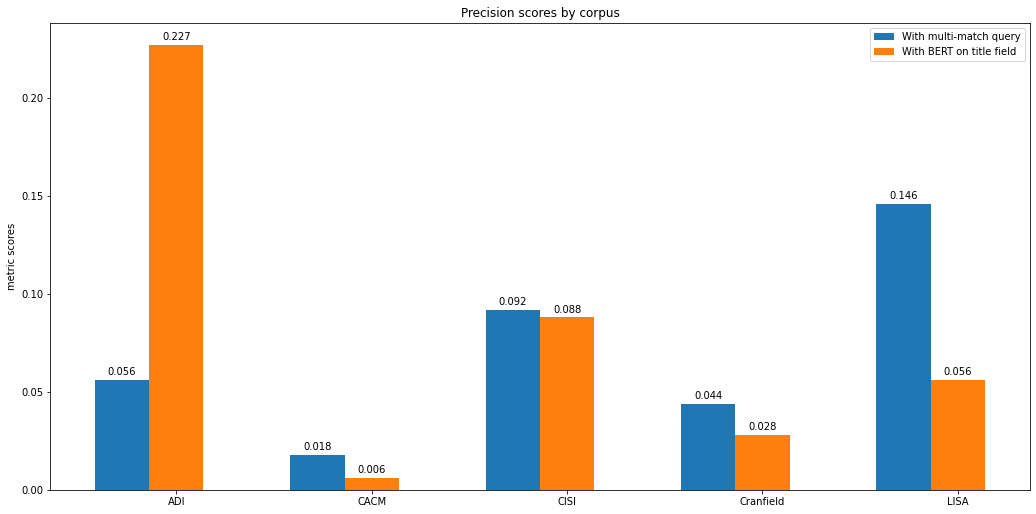

In [28]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

match_metrics_precision = []
match_metrics_precision.append(round(adi_res_match_precision['metric_score'], 3))
match_metrics_precision.append(round(cacm_res_match_precision['metric_score'], 3))
match_metrics_precision.append(round(cisi_res_match_precision['metric_score'], 3))
match_metrics_precision.append(round(cran_res_match_precision['metric_score'], 3))
match_metrics_precision.append(round(lisa_res_match_precision['metric_score'], 3))

bert_title_metrics_precision = []
bert_title_metrics_precision.append(round(adi_res_bert_title_precision['metric_score'], 3))
bert_title_metrics_precision.append(round(cacm_res_bert_title_precision['metric_score'], 3))
bert_title_metrics_precision.append(round(cisi_res_bert_title_precision['metric_score'], 3))
bert_title_metrics_precision.append(round(cran_res_bert_title_precision['metric_score'], 3))
bert_title_metrics_precision.append(round(lisa_res_bert_title_precision['metric_score'], 3))

labels = ['ADI','CACM', 'CISI','Cranfield', 'LISA']

x = np.arange(len(labels))*1.8  # the label locations

width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, match_metrics_precision , width, label='With multi-match query')
rects2 = ax.bar(x, bert_title_metrics_precision, width, label='With BERT on title field')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('Precision scores by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()

In [29]:
from tabulate import tabulate

match_metrics_precision.insert(0, 'multi-match query') 
bert_title_metrics_precision.insert(0, 'BERT on title field')

l = [match_metrics_precision, bert_title_metrics_precision]
table = tabulate(l, headers=['ADI','CACM', 'CISI','cranfield', 'LISA'], tablefmt='orgtbl')

print(table)

|                     |   ADI |   CACM |   CISI |   cranfield |   LISA |
|---------------------+-------+--------+--------+-------------+--------|
| multi-match query   | 0.056 |  0.018 |  0.092 |       0.044 |  0.146 |
| BERT on title field | 0.227 |  0.006 |  0.088 |       0.028 |  0.056 |


### F-Score

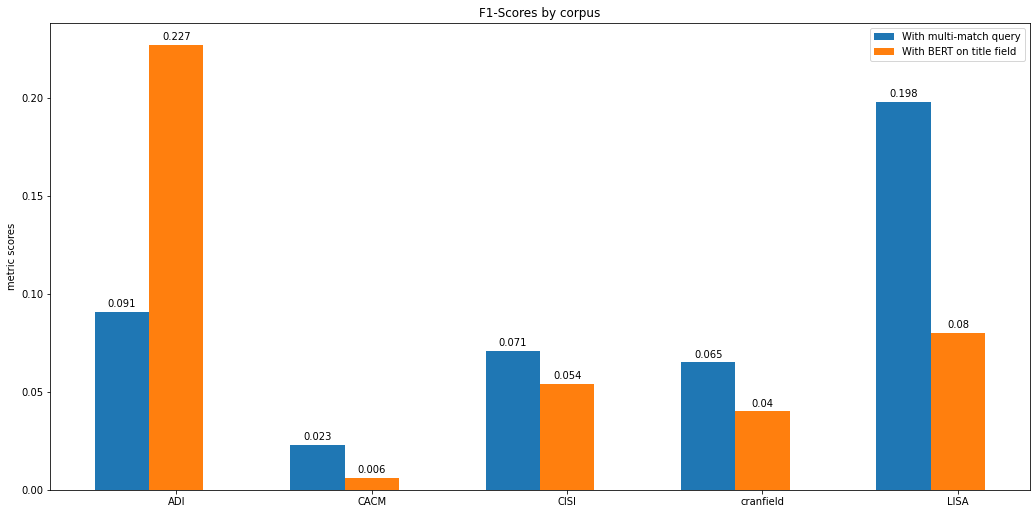

In [31]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def f_score(recall,precision):
  if recall or precision != 0:
    fscore = 2*((recall*precision)/(recall+precision))
    return fscore
  else: return 0

match_metrics_fscore = []
match_metrics_fscore.append(round(f_score(adi_res_match_recall['metric_score'], adi_res_match_precision['metric_score']),3))
match_metrics_fscore.append(round(f_score(cacm_res_match_recall['metric_score'], cacm_res_match_precision['metric_score']),3))
match_metrics_fscore.append(round(f_score(cisi_res_match_recall['metric_score'], cisi_res_match_precision['metric_score']),3))
match_metrics_fscore.append(round(f_score(cran_res_match_recall['metric_score'], cran_res_match_precision['metric_score']),3))
match_metrics_fscore.append(round(f_score(lisa_res_match_recall['metric_score'], lisa_res_match_precision['metric_score']),3))

bert_title_metrics_fscore = []
bert_title_metrics_fscore.append(round(f_score(adi_res_bert_title_recall['metric_score'], adi_res_bert_title_precision['metric_score']),3))
bert_title_metrics_fscore.append(round(f_score(cacm_res_bert_title_recall['metric_score'], cacm_res_bert_title_precision['metric_score']),3))
bert_title_metrics_fscore.append(round(f_score(cisi_res_bert_title_recall['metric_score'], cisi_res_bert_title_precision['metric_score']),3))
bert_title_metrics_fscore.append(round(f_score(cran_res_bert_title_recall['metric_score'], cran_res_bert_title_precision['metric_score']),3))
bert_title_metrics_fscore.append(round(f_score(lisa_res_bert_title_recall['metric_score'], lisa_res_bert_title_precision['metric_score']),3))

labels = ['ADI','CACM', 'CISI','cranfield', 'LISA']

x = np.arange(len(labels))*1.8  # the label locations

width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, match_metrics_fscore , width, label='With multi-match query')
rects2 = ax.bar(x, bert_title_metrics_fscore, width, label='With BERT on title field')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('F1-Scores by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()

In [33]:
from tabulate import tabulate

match_metrics_fscore.insert(0, 'multi-match query') 
bert_title_metrics_fscore.insert(0, 'BERT on title field')

l = [match_metrics_fscore, bert_title_metrics_fscore]
table = tabulate(l, headers=['ADI','CACM', 'CISI','cranfield', 'LISA'], tablefmt='orgtbl')

print(table)

|                     |   ADI |   CACM |   CISI |   cranfield |   LISA |
|---------------------+-------+--------+--------+-------------+--------|
| multi-match query   | 0.091 |  0.023 |  0.071 |       0.065 |  0.198 |
| BERT on title field | 0.227 |  0.006 |  0.054 |       0.04  |  0.08  |


Read more on this experiment on our [website](https://pragmalingu.de/docs/experiments/experiment1).